# Import needed libraries

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

# Load Data

In [2]:
trainingset = 'train'
testset = 'test'

batch_size = 32
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

#Generate batches of image data and their corresponding labels from a directory structure
train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))


Found 6369 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image input (118, 224, 3)
Classes: ['0', '1', '2', '3', '4']
Loaded 6369 training samples from 5 classes.
Loaded 2749 test samples from 5 classes.


0


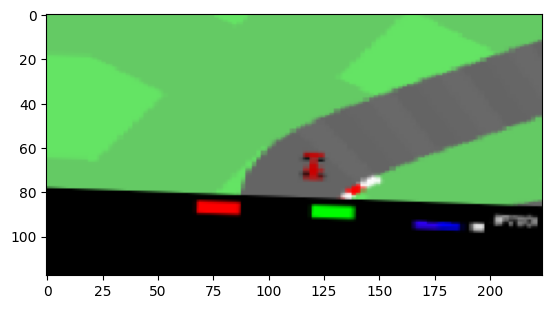

2


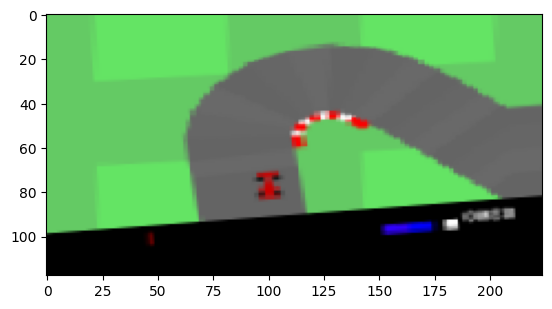

In [6]:
n = 2
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

# Data distribution

# I Model

In [13]:

def AlexNet(input_shape, num_classes, regl2 = 0.0001, lr=0.0001):

    model = Sequential()

    # C1 Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),\
                     strides=(2,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)

    # D1 Dense Layer
    model.add(Dense(1000, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    adam = optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

# create the model
model = AlexNet(input_shape,num_classes)
model.summary()

# history of results (set to None when initializing a new mdoel)
history = None


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 activation_19 (Activation)  (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 27, 27, 96)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_18 (Ba  (None, 27, 27, 96)        384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 13, 13, 96)        0         
 ng2D)                                                           
                                                      

## Train

In [16]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

epochs = 30  # sets number of epochs

try:
    h = model.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps) # validation set????
except KeyboardInterrupt:
    pass

# append current history

if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    history['val_loss'].extend(h.history['val_loss'])
    history['val_accuracy'].extend(h.history['val_accuracy'])

Epoch 1/30
199/199 [==============================] - 173s 866ms/step - loss: 2.0318 - accuracy: 0.3443 - val_loss: 1.7393 - val_accuracy: 0.1179
Epoch 2/30
199/199 [==============================] - 159s 798ms/step - loss: 1.8344 - accuracy: 0.3898 - val_loss: 1.4912 - val_accuracy: 0.6308
Epoch 3/30
199/199 [==============================] - 155s 777ms/step - loss: 1.7721 - accuracy: 0.4223 - val_loss: 1.1877 - val_accuracy: 0.6835
Epoch 4/30
199/199 [==============================] - 150s 753ms/step - loss: 1.7165 - accuracy: 0.4335 - val_loss: 1.4500 - val_accuracy: 0.5689
Epoch 5/30
199/199 [==============================] - 149s 748ms/step - loss: 1.7073 - accuracy: 0.4310 - val_loss: 2.2964 - val_accuracy: 0.2466
Epoch 6/30
199/199 [==============================] - 151s 758ms/step - loss: 1.6651 - accuracy: 0.4463 - val_loss: 1.9869 - val_accuracy: 0.1473
Epoch 7/30
199/199 [==============================] - 150s 751ms/step - loss: 1.6565 - accuracy: 0.4437 - val_loss: 1.2265 -

## Save model

In [19]:
models_dir = 'models'
modelname = 'model1_%d_epochs' %len(history['loss'])

def savemodel(problem,model,history):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)
    filename = os.path.join(models_dir, '%s_history.pkl' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history, f)
    print("History saved successfully on file %s\n" %filename)

# Save model and history
savemodel(modelname,model,history)


/Users/ya/Visual Studio/ML_HW2/ML/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Model saved successfully on file models/model1_30_epochs.h5

History saved successfully on file models/model1_30_epochs_history.pkl



## Evaluate

In [20]:
test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)



Found 2749 images belonging to 5 classes.
86/86 [==============================] - 14s 163ms/step - loss: 1.2400 - accuracy: 0.6424
Test loss: 1.240016
Test accuracy: 0.642415
